In [1]:
%run SetUp.ipynb

Configuration.

In [2]:
## Configuration
Title = "Exmp_Deactivation"
device = 'cpu' # "cuda:1" if torch.cuda.is_available() else "cpu"
output_path = f"./Results/{Title}"
create_directory(output_path)


# data setting
n=3 # number of data
d=3 # dimension of data


# input X is shape of n x d 
X = torch.tensor([[1, 0, 2], # x1
                  [1, 2, 0], # x2
                  [2, 0., 0]], # x3
                 device=device).float()
# label Y is shape of n x 1
Y = torch.tensor([[0.05], [6], [0.5]], device=device).float()

H = X.t().matmul(X) # The Hessian Matirx
q = (X * Y).sum(0)

U, D, _ = torch.svd(H) # eigenvector decompsition of H
print("eigenvalues of H =", D)
w_star = torch.linalg.inv(H).matmul(q) # the global minimum of the linear network
w_star_cpu = w_star.cpu()
zero = np.array([0,0,0.])
print("w* =", w_star)

eigenvalues of H = tensor([8.0000, 4.0000, 2.0000])
w* = tensor([ 0.2500,  2.8750, -0.1000])


Single-Layer Linear and ReLU Networks

In [3]:
w0 = 0.0001 * torch.rand(1,d) # initialization with small norm
print("w0=", w0)

# 
linear_net = Linear_Net()
linear_net.module[0].weight = nn.Parameter(copy.deepcopy(w0)) 
linear_net.to(device)
relu_net = ReLU_Net()
relu_net.module[0].weight = nn.Parameter(copy.deepcopy(w0)) 
relu_net.to(device)


# optimization Setting
lr = 0.005
criterion = nn.MSELoss()
linear_optimizer = optim.SGD(linear_net.parameters(), lr=lr)
relu_optimizer = optim.SGD(relu_net.parameters(), lr=lr)

w0= tensor([[5.5205e-06, 9.7879e-05, 9.0260e-05]])


In [4]:
linear_tr = np.empty((0,d)) # Gradient flow of the linear network
relu_tr = np.empty((0,d)) # Gradient flow of the ReLU network
linear_loss_tr = np.empty(0) # Loss of the ReLU network
relu_loss_tr = np.empty(0) # Loss of the ReLU network

Epochs = 10000
log_period = 10
for epoch in range(Epochs) :
    linear_loss = criterion(linear_net(X), Y)
    linear_loss.backward()
    linear_optimizer.step()
    linear_net.zero_grad()
    
    relu_loss = criterion(relu_net(X), Y)
    relu_loss.backward()
    relu_optimizer.step()
    relu_net.zero_grad()
    
#     if (net(X)>0).prod().item() != 1 :
#         print(f"At epoch {epoch}, deactivation occurs !!!!!!!!!!")
#         print(f"output is {net(X).detach()}")    
    
    if epoch % log_period == 0 :
        linear_tr = np.append(linear_tr, linear_net.weight(), axis=0)
        relu_tr = np.append(relu_tr, relu_net.weight(), axis=0)
        linear_loss_tr = np.append(linear_loss_tr, linear_loss.item())
        relu_loss_tr = np.append(relu_loss_tr, relu_loss.item())

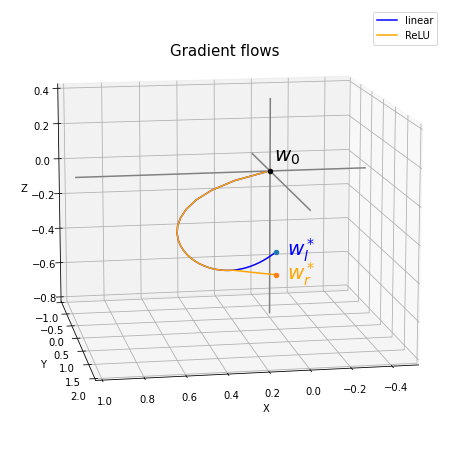

In [5]:
# draw axis
xlim_l = -0.5 ; xlim_u = 1.0
ylim_l = -1.0 ; ylim_u = 2.0
zlim_l = -0.8 ; zlim_u = 0.4
x_axis = np.linspace(xlim_l,xlim_u,10)
y_axis = np.linspace(ylim_l,ylim_u,10)
z_axis = np.linspace(zlim_l,zlim_u,10)

plt.ion()
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')
ax.set_title("Gradient flows", fontsize=15, y=0.95)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.plot3D(x_axis, np.zeros_like(x_axis), np.zeros_like(x_axis), 'gray') # x-axis
ax.plot3D(np.zeros_like(y_axis), y_axis, np.zeros_like(y_axis), 'gray') # y-axis
ax.plot3D(np.zeros_like(z_axis), np.zeros_like(z_axis), z_axis, 'gray') # z-axis


# camera angle
ax.azim = 80
ax.dist = 9
ax.elev = 12

#draw eigenvetors

# draw hyperplanes
# x,y = np.meshgrid(line,line)
# z1 = - (X[0][0].item()*x + X[0][1].item()*y) / X[0][2].item()
# z2 = - (X[1][0].item()*x + X[1][1].item()*y) / X[1][2].item()
# z3 = - (X[2][0].item()*x + X[2][1].item()*y) / X[2][2].item()
# z2[z2>lim] = np.nan
# z2[z2<-lim] = np.nan
# z3[z3>lim] = np.nan
# z3[z3<-lim] = np.nan
# ax.plot_surface(x, y, z1, alpha=0.5)
# ax.plot_surface(x, y, z2, alpha=0.5)
# ax.plot_surface(x, y, z3, alpha=0.5)




ax.scatter3D(zero[0], zero[1], zero[2], color='black')
ax.text(-0.02, 0, 0.05, "$w_0$", size=20, zorder=1, color='black')
w_star_linear = linear_net.weight()[0]
w_star_relu = relu_net.weight()[0]
ax.scatter3D(w_star_linear[0], w_star_linear[1], w_star_linear[2])
ax.text(w_star_linear[0]-0.05, w_star_linear[1], w_star_linear[2]-0.02, "$w_l^*$", size=20, zorder=1, color='blue')
ax.scatter3D(w_star_relu[0], w_star_relu[1], w_star_relu[2])
ax.text(w_star_relu[0]-0.05, w_star_relu[1], w_star_relu[2]-0.03, "$w_r^*$", size=20, zorder=-11, color='orange')


ax.set_xlim(xlim_l, xlim_u)
ax.set_ylim(ylim_l, ylim_u)
ax.set_zlim(zlim_l, zlim_u)

# Convergnenc Path
ax.plot3D(linear_tr[:,0], linear_tr[:,1], linear_tr[:,2], color="blue", label="linear")
ax.plot3D(relu_tr[:,0], relu_tr[:,1], relu_tr[:,2], color="orange", label="ReLU")
ax.legend()
savefig(f'{output_path}/convergence_{Epochs}.png')

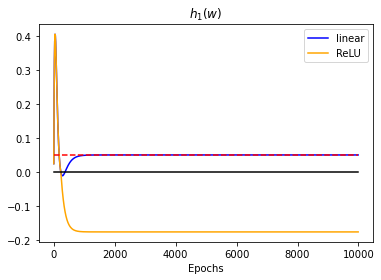

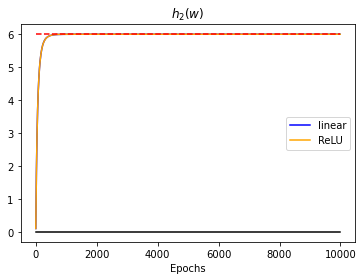

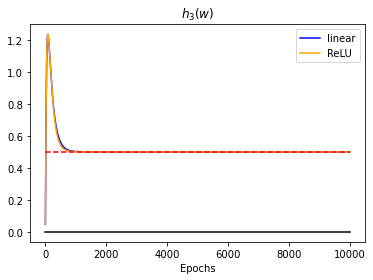

In [6]:
linear_tr_torch = torch.tensor(linear_tr).float()
relu_tr_torch = torch.tensor(relu_tr).float()
for i in range(n):
    linear_h1 = linear_tr_torch.matmul(X[i])
    relu_h1 = relu_tr_torch.matmul(X[i])
    plt.plot(log_period*np.arange(len(linear_h1)), linear_h1, color='blue', label="linear")
    plt.plot(log_period*np.arange(len(relu_h1)), relu_h1, color='orange', label="ReLU")
    plt.plot(log_period*np.arange(len(linear_h1)), np.zeros(len(linear_h1)), 'k') # x axis
    plt.plot(log_period*np.arange(len(linear_h1)), Y[i] * np.ones(len(linear_h1)), 'r--') # asymptotic
    plt.xlabel('Epochs')
    plt.title(f'$h_{i+1}(w)$')
    plt.legend()
    savefig(f'{output_path}/h{i+1}_{Epochs}.png')

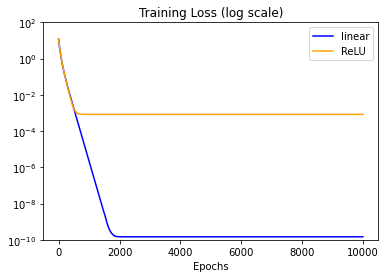

In [7]:
plt.plot(log_period*np.arange(len(linear_loss_tr)), linear_loss_tr, color='blue', label="linear")
plt.plot(log_period*np.arange(len(linear_loss_tr)), relu_loss_tr, color='orange', label="ReLU")
# plt.plot(log_period*np.arange(len(linear_loss_tr)), np.zeros(len(linear_loss_tr)), 'k') # x axis
plt.xlabel('Epochs')
plt.title('Training Loss (log scale)')
plt.ylim(0.0000000001,100)
plt.yscale('log')
plt.legend()
savefig(f'{output_path}/Loss_{Epochs}.png')